<a href="https://colab.research.google.com/github/dhan16/colabs/blob/master/ml/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression: Theory







Given data of n observations {**x<sub>i</sub>**, y<sub>i</sub>}<sub>i=1:n</sub> with y<sub>i</sub> a scalar response and **x<sub>i</sub>** a column vector of size p:
* y<sub>i</sub> = β<sub>1</sub>x<sub>i1</sub> + ... + β<sub>p</sub>x<sub>ip</sub> + ε<sub>i</sub> = x<sub>i</sub><sup>T</sup>β + ε<sub>i</sub>

* or, in vector form: y<sub>i</sub> = **x<sub>i</sub>**<sup>T</sup>**β** + ε<sub>i</sub>

* or, stacking the n equations together in matrix notation: **y** = X**β** + **ε**

### Ordinary Least Squares Solution
Find the coefficients **β** which fit the equations "best", **$\hat{β}$** = arg min S(**β**), where

* S(**β**) = ||**y** - X**β**||<sup>2</sup>

* The solution is: **$\hat{β}$** = (X<sup>T</sup>X)<sup>-1</sup> X<sup>T</sup>**y**

where (X<sup>T</sup>X)<sup>-1</sup> X<sup>T</sup> is  the Moore–Penrose pseudoinverse matrix of X

### Reference
* https://en.wikipedia.org/wiki/Ordinary_least_squares#Linear_model


# Visualisation Functions

In [27]:
#@title plot2D
import matplotlib.pyplot as plt

def plot2D(x, y, beta):
  plt.plot(x, y, 'o', label='data')
  xx = np.linspace(min(x), max(x), 101)
  yy = beta[0] + beta[1]*xx
  plt.plot(xx, yy, label='least squares fit, $y = a + bx$')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend(framealpha=1, shadow=True)
  plt.grid(alpha=0.25)
  plt.show()

# Load Data


In [38]:
#@title randomLinearData()
import numpy as np

def randomLinearData(beta, n):
  # seed random number generator
  np.random.seed(100)
  x = 1000 * np.random.rand(n)
  e = 100 * np.random.rand(len(x))
  y = beta[0] + x*beta[1] + e
  return (x, y)

* https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/validation_and_test_sets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=validation_tf2-colab&hl=en

# Linear Regression: manual OLS


In [34]:
#@title Import modules
import numpy as np
import pandas as pd
from scipy.linalg import lstsq

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html#scipy.linalg.lstsq

[104.43612899   2.99467652]


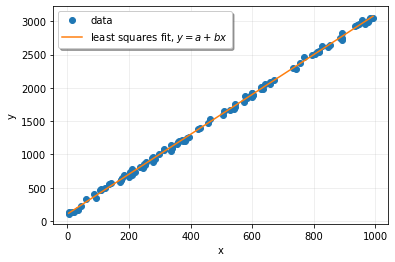

In [39]:
(x, y) = randomLinearData([50, 3], 100)

M = x[:, np.newaxis]**[0, 1]
p, res, rnk, s = lstsq(M, y)

print(p)
plot2D(x, y, p)

# Linear Regression: scikit-learn OLS

* https://datatofish.com/multiple-linear-regression-python/
* https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/


# Linear Regression: Gradient descent with manual gradient



https://towardsdatascience.com/calculating-gradient-descent-manually-6d9bee09aa0b

https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/

https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931



# Linear Regression; Gradient descent with manual automatic differentiation


* https://mdrk.io/introduction-to-automatic-differentiation/


## Linear Regression: TensorFlow


References

* https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/validation_and_test_sets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=validation_tf2-colab&hl=en#scrollTo=FBhNIdUatOU6

* https://colab.research.google.com/github/kaustubholpadkar/Predicting-House-Price-using-Multivariate-Linear-Regression/blob/master/Multivariate_Linear_Regression_Python.ipynb

* https://www.coursera.org/projects/regression-automatic-differentiation-tensorflow



In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#@title Import modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# ML

## Feature Engineering

* Load data
* Shuffle
* Split into training, validation and test. 
* Scale label column to meaningful values

Features
* Bucketize, cross 
* Scale features - min max or z scale


References

* https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=representation_tf2-colab&hl=en


## Define and Train Models
* create model
* train model
* plot loss curves
